# Week 7 Data acqusition from Biosemi

In [131]:
# import require library for preprocess
import mne
import numpy as np
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt
from mne.datasets import eegbci
import scipy
import pickle
import seaborn as sns
from scipy.signal import filtfilt
import pyxdf

# import require library for classification
from sklearn.svm import SVC # SVM library
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA library
from sklearn.neighbors import KNeighborsClassifier # KNN library

from sklearn.metrics import classification_report,confusion_matrix # Result representation

## 1 Read recorded data from Biosemi (bdf file)

In [132]:
# read biosami file (bdf)
raw_bio = mne.io.read_raw_bdf("databiosemi/s101_b2.bdf", preload=True) 
eegbci.standardize(raw_bio)

# Set channel location for data

montage = make_standard_montage("biosemi64")
raw_bio.set_montage(montage, on_missing='ignore')

Extracting EDF parameters from c:\Users\bcc35\Downloads\bci_code\databiosemi\s101_b2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 127999  =      0.000 ...   249.998 secs...


Measurement date,"May 09, 2025 17:20:21 GMT"
Experimenter,Unknown
Participant,
Digitized points,67 points
Good channels,"72 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,104.00 Hz


In [133]:
raw_bio = raw_bio.resample(128, verbose = False)
raw_bio

Measurement date,"May 09, 2025 17:20:21 GMT"
Experimenter,Unknown
Participant,
Digitized points,67 points
Good channels,"72 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,0.00 Hz
Lowpass,64.00 Hz


**check channel names**

In [134]:
raw_bio.ch_names

['Fp1',
 'AF7',
 'AF3',
 'F1',
 'F3',
 'F5',
 'F7',
 'FT7',
 'FC5',
 'FC3',
 'FC1',
 'C1',
 'C3',
 'C5',
 'T7',
 'TP7',
 'CP5',
 'CP3',
 'CP1',
 'P1',
 'P3',
 'P5',
 'P7',
 'P9',
 'PO7',
 'PO3',
 'O1',
 'Iz',
 'Oz',
 'POz',
 'Pz',
 'CPz',
 'Fpz',
 'Fp2',
 'AF8',
 'AF4',
 'AFz',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT8',
 'FC6',
 'FC4',
 'FC2',
 'FCz',
 'Cz',
 'C2',
 'C4',
 'C6',
 'T8',
 'TP8',
 'CP6',
 'CP4',
 'CP2',
 'P2',
 'P4',
 'P6',
 'P8',
 'P10',
 'PO8',
 'PO4',
 'O2',
 'EXG1',
 'EXG2',
 'EXG3',
 'EXG4',
 'EXG5',
 'EXG6',
 'EXG7',
 'EXG8',
 'STATUS']

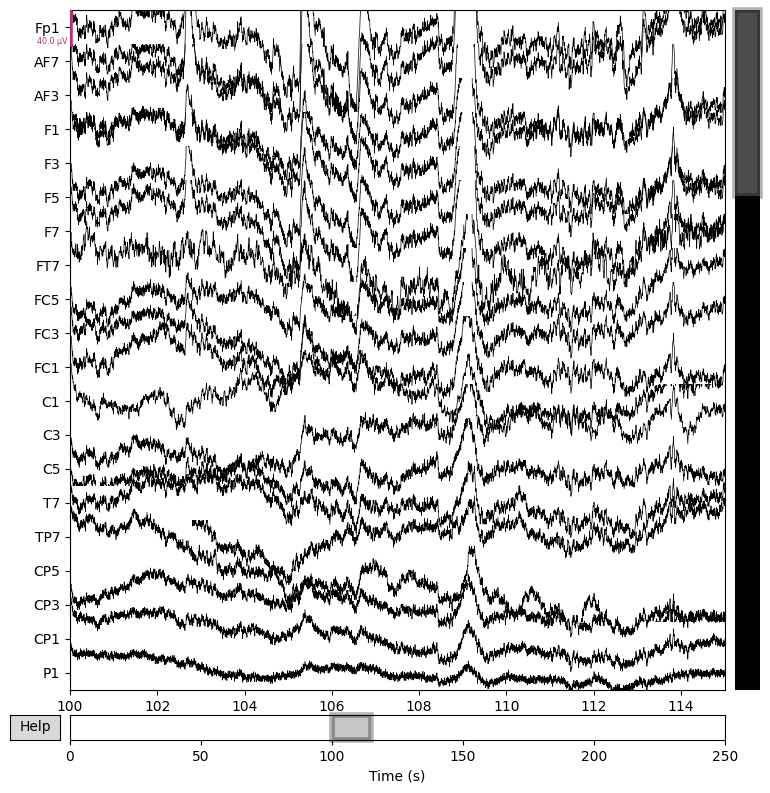

...


In [135]:
raw_bio.plot(start = 100, duration = 15)
print('...')

## 2. Apply filter

**raw data PSD plotting**

Effective window size : 16.000 (s)


c:\Users\bcc35\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


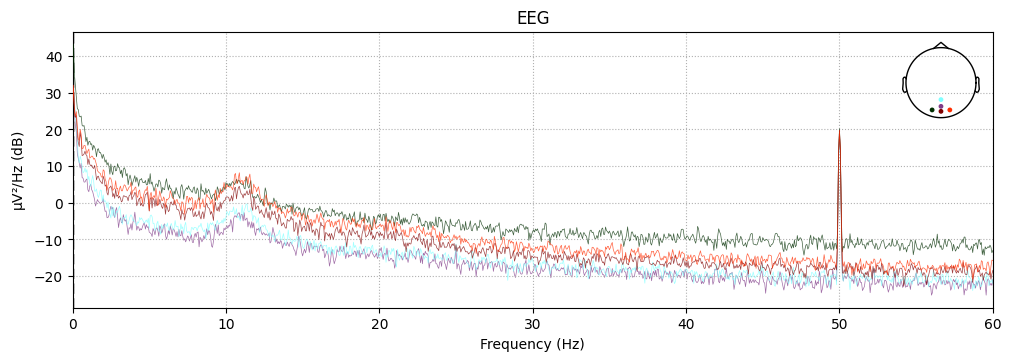

In [136]:
select_channels = ['O1', 'Oz', 'O2', 'Pz', 'POz']
raw_bio.compute_psd(fmax=60).plot(picks=select_channels)
plt.show()

**apply notch and band-pass filter**

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Effective window size : 16.000 (s)


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.0s finished
c:\Users\bcc35\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


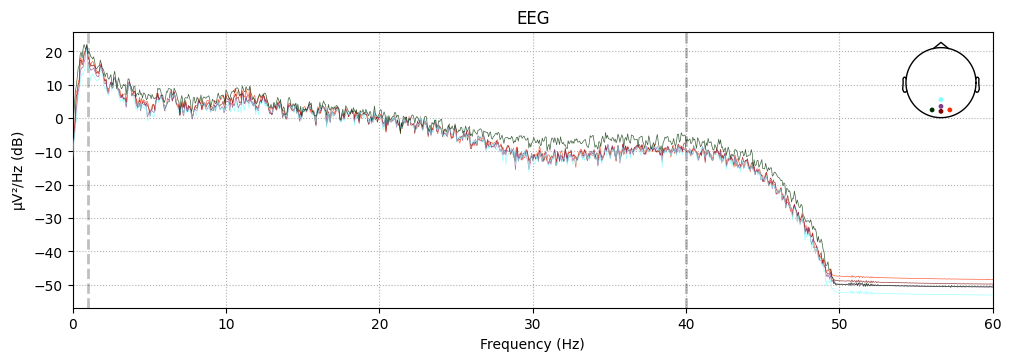

In [137]:
raw_bio = raw_bio.set_eeg_reference('average')  
bio_filter = raw_bio.copy().filter(l_freq=1, h_freq=40) #band-pass function
bio_filter = bio_filter.copy().notch_filter(freqs=50) #notch filter function
bio_filter.compute_psd(fmax=60).plot(picks=select_channels)
plt.show()

# 3. Data Epoching

**Biosemi**

In [138]:
import pandas as pd

df = pd.read_csv('Tai1.csv')
response = df.get(key="response.keys")
response = response[1:-2]
data_response = response.to_numpy()

In [139]:
events = mne.find_events(raw_bio, shortest_event = 0) #command for get events and timestamp

#Define what event numbers is
event_dict =  {'101': 101,
'102': 102}
print(events)

Trigger channel STATUS has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
60 events found on stim channel STATUS
Event IDs: [101 102]
[[ 2159     0   101]
 [ 2663     0   101]
 [ 3147     0   101]
 [ 3634     0   101]
 [ 4115     0   101]
 [ 4583     0   101]
 [ 5082     0   101]
 [ 5550     0   101]
 [ 6023     0   101]
 [ 6501     0   101]
 [ 6971     0   101]
 [ 7440     0   102]
 [ 7925     0   101]
 [ 8419     0   101]
 [ 8927     0   101]
 [ 9426     0   101]
 [ 9919     0   102]
 [10380     0   102]
 [10877     0   101]
 [11380     0   101]
 [11878     0   101]
 [12347     0   101]
 [12847     0   101]
 [13355     0   101]
 [13855     0   101]
 [14364     0   101]
 [14832     0   101]
 [15322     0   102]
 [15796     0   101]
 [16271     0   102]
 [16762     0   101]
 [17263     0   101]
 [17761     0   101]
 [18261     0   101]
 [18725     0   101]
 [19210     0   101]
 

In [140]:
Bio_Epochs = mne.Epochs(raw_bio, events, 
    tmin= -0.5,  
    tmax= 1.0,    
    event_id=event_dict,
    preload = True,
    event_repeated='drop',
    baseline=(-0.5, 0.0),
    verbose=True
    )

Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 60 events and 193 original time points ...
0 bad epochs dropped


In [141]:
Bio_Epochs

Number of events,60
Events,101: 48102: 12
Time range,-0.500 – 1.000 s
Baseline,-0.500 – 0.000 s


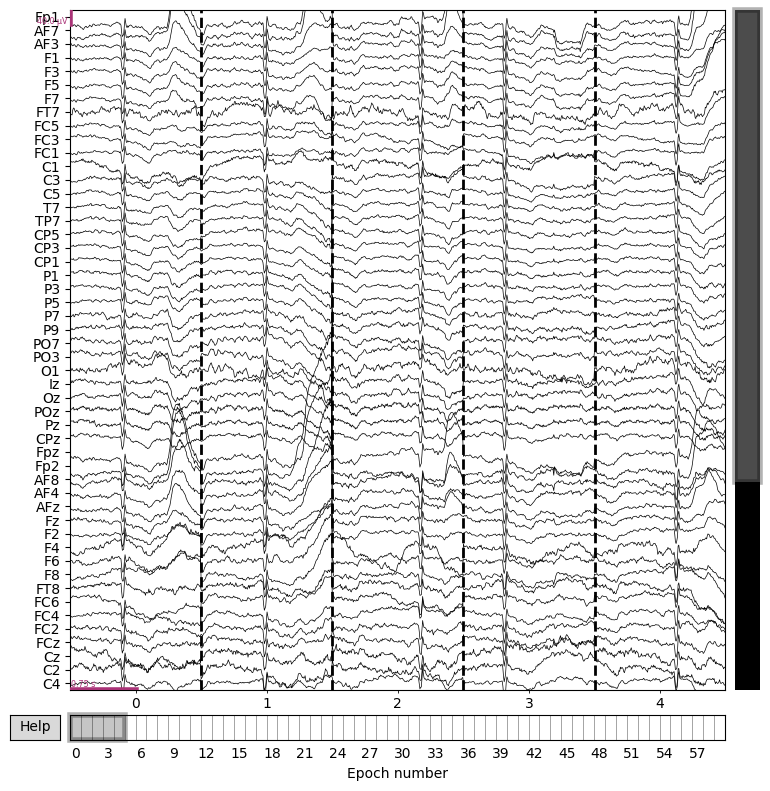

...


In [142]:
Bio_Epochs.plot(n_epochs = 5)
print('...')

In [143]:
evoked_target = Bio_Epochs['102'].average()
# evoked_subtarget = OpenBCI_epochs['101'].average()
evoked_nontarget = Bio_Epochs['101'].average()

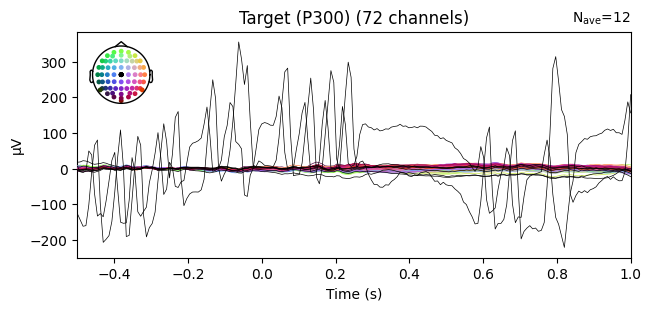

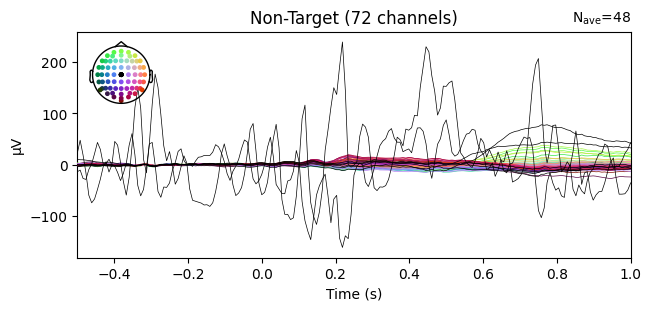

In [144]:
evoked_target.plot(spatial_colors=True, titles='Target (P300)')
# evoked_subtarget.plot(spatial_colors=True, titles='SubTarget (P300)')
evoked_nontarget.plot(spatial_colors=True, titles='Non-Target')
plt.show()


combining channels using "mean"


combining channels using "mean"


C:\Users\bcc35\AppData\Local\Temp\ipykernel_70388\3306011302.py:1: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


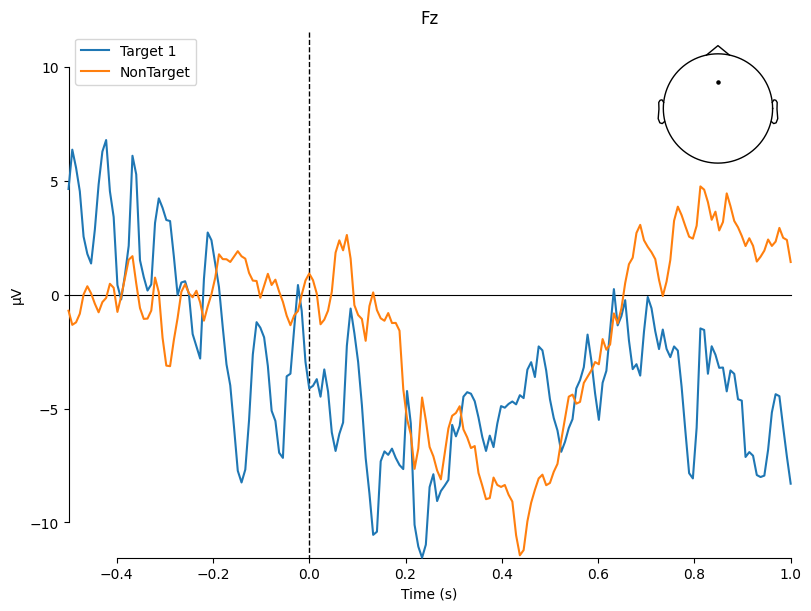

C:\Users\bcc35\AppData\Local\Temp\ipykernel_70388\3306011302.py:11: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


combining channels using "mean"
combining channels using "mean"


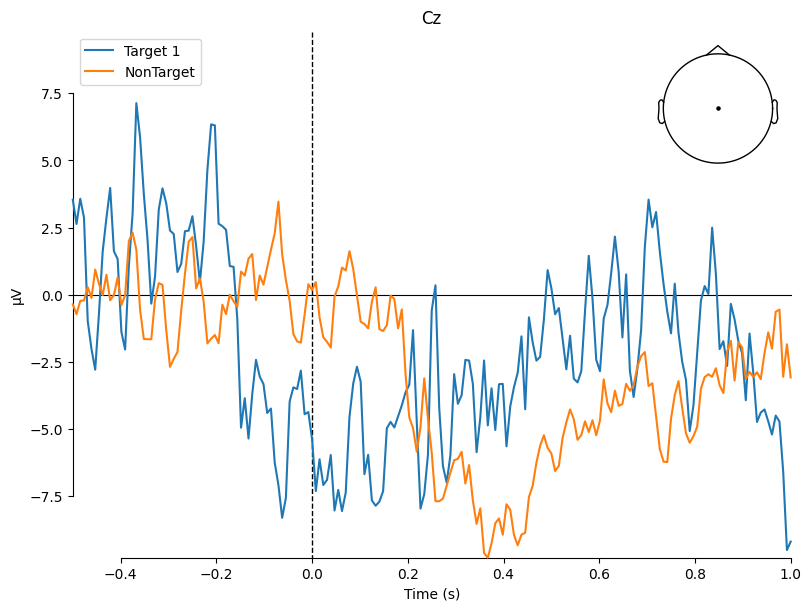

combining channels using "mean"
combining channels using "mean"


C:\Users\bcc35\AppData\Local\Temp\ipykernel_70388\3306011302.py:21: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


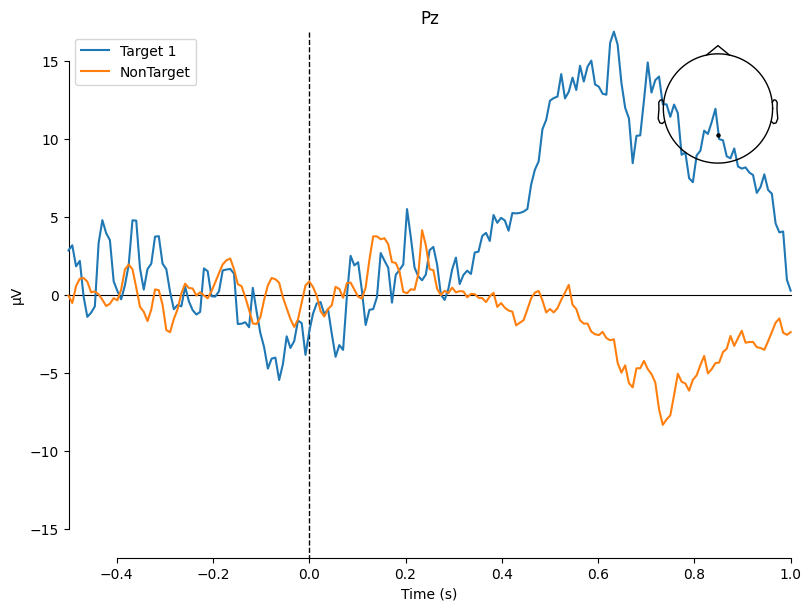

combining channels using "mean"
combining channels using "mean"


C:\Users\bcc35\AppData\Local\Temp\ipykernel_70388\3306011302.py:31: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


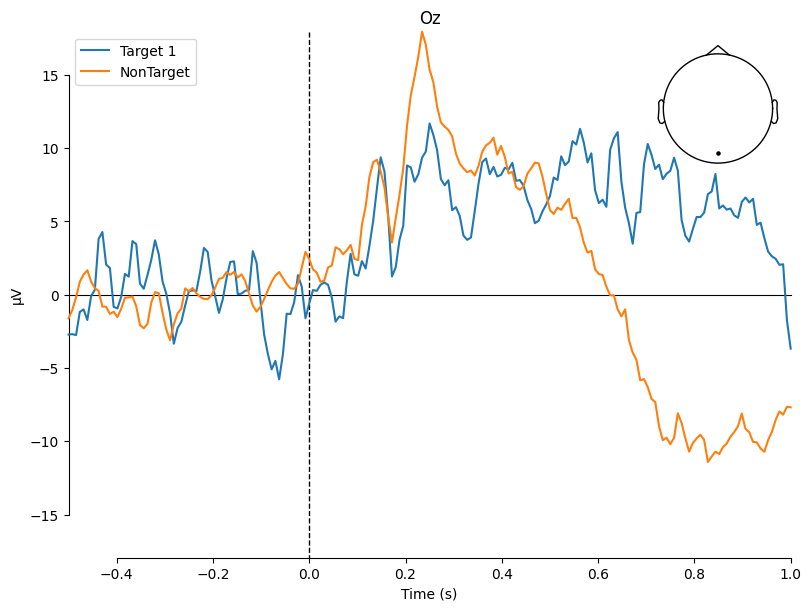

In [145]:
mne.viz.plot_compare_evokeds(
    {
        'Target 1': evoked_target,
        # 'Target 2': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='Fz',
    combine='mean'
)
plt.show()
mne.viz.plot_compare_evokeds(
    {
        'Target 1': evoked_target,
        # 'Target 2': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='Cz',
    combine='mean'
)
plt.show()
mne.viz.plot_compare_evokeds(
    {
        'Target 1': evoked_target,
        # 'Target 2': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='Pz',
    combine='mean'
)

mne.viz.plot_compare_evokeds(
    {
        'Target 1': evoked_target,
        # 'Target 2': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='Oz',
    combine='mean'
)
plt.show()

## 4.PSD plotting

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Averaging across epochs...


c:\Users\bcc35\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\bcc35\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


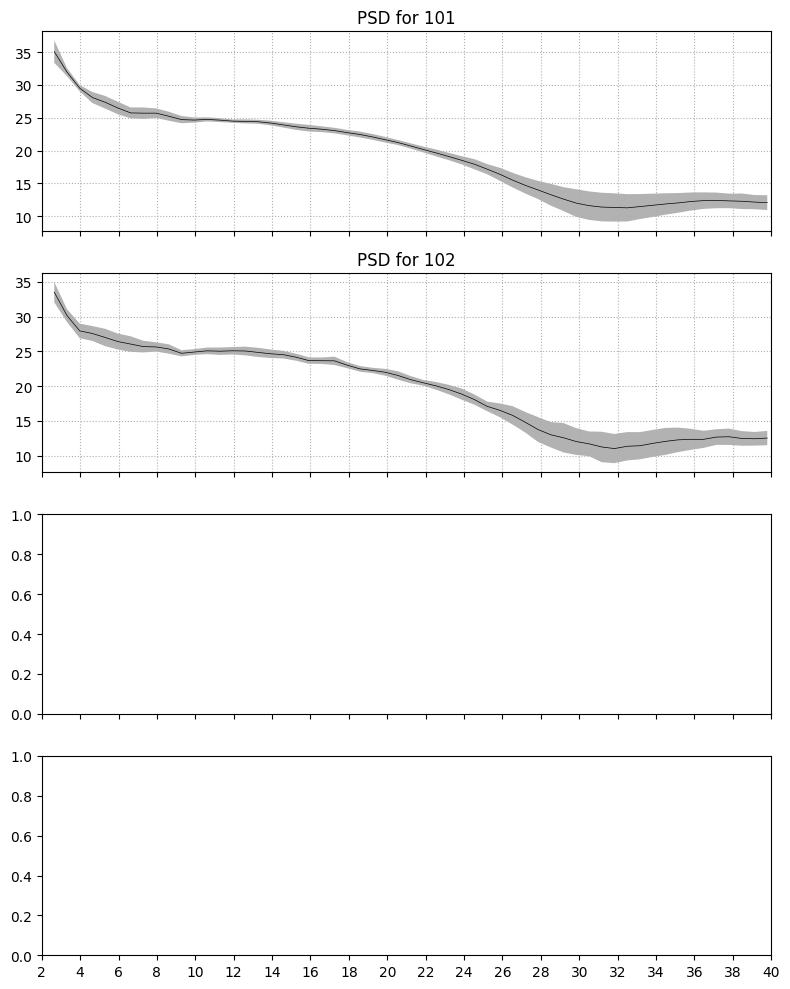

In [146]:
# Compute the PSD for different frequency epochs
ssvep_chans = ['Fz','Cz','Pz'] 
psd_101 = Bio_Epochs['101'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)
psd_102 = Bio_Epochs['102'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)
# psd_24Hz = Bio_Epochs['24Hz'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)
# psd_30Hz = Bio_Epochs['30Hz'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)

# Store PSD objects and titles
psd_data = [(psd_101, '101'), (psd_102, '102')]

# Create subplots (1 column, 4 rows)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)

# Plot each PSD computation in a separate subplot
for ax, (psd, title) in zip(axes, psd_data):
    psd.plot(average=True, amplitude=False, picks="data", exclude="bads", axes=ax)
    ax.set_title(f'PSD for {title}')
    ax.set_xticks(np.arange(2, 41, 2))  # Set x-axis ticks from 2 to 60 Hz
    ax.set_xticklabels(np.arange(2, 41, 2))  # Set x-axis labels

plt.tight_layout()
plt.show()